In [30]:
import pandas as pd 
import numpy as np
import pygeohash as gh
import datetime

df = pd.read_csv('bird_data.csv')
df['geohash']= df.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=6), axis=1) # 12 block radius # changed from 8 


In [31]:
#find the day of the week 
df['day_of_week'] = df['timestamp'].apply(lambda x:datetime.datetime.strptime(x,'%d-%b-%Y %H:%M:%S.%f').strftime('%w'))

In [32]:
df["day_of_week"] = pd.to_numeric(df["day_of_week"]) # convert to numeric 
df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x < 1 or x > 4 else 0) # create weekend variable
df['low_battery'] = np.where(df['battery_level'] <= 90, 1, 0) # find low battery scooters 

In [33]:
# convert string to datetime string for parsing out the month, hour, and other times 
df.timestamp = pd.to_datetime(df.timestamp, format='%d-%b-%Y %H:%M:%S.%f')
df['month'] = df.timestamp.apply(lambda x: x.month)
df['day'] = df.timestamp.apply(lambda x: x.day)
df['hour'] = df.timestamp.apply(lambda x: x.hour)
df['minute'] = df.timestamp.apply(lambda x: x.minute)

In [11]:
#select columns for df 
bird_df = df[['bird_id','geohash', 'day_of_week', 'weekend', 'low_battery', 'month', 'day', 'hour', 'minute']]
bird_df.to_csv("bird_data-reformated-2.csv", index = None, header=True)

In [2]:
# from rpy2.robjects.vectors import StrVector
# import rpy2.robjects.packages as rpackages
# import rpy2.robjects as robjects

# def create_scooter_counts(data):
#     base = rpackages.importr('base')
#     packageNames = ('tidyverse')
#     utils = rpackages.importr('utils')
#     utils.chooseCRANmirror(ind=1)

#     packnames_to_install = [x for x in packageNames if not rpackages.isinstalled(x)]

#     if len(packnames_to_install) > 0:
#         utils.install_packages(StrVector(packnames_to_install))
#     tidyverse = rpackages.importr('tidyverse')
#     robjects.r['options'](warn=-1)
#     create_file = robjects.r('''
#         function(results_file) {
#             df <- read_csv(results_file, col_names = T)
#             nightly_pick_up <- df  %>% filter(hour >= 21 & hour <= 23)  %>% filter(low_battery != 0)# filter by 9PM -11:55PM data 
#             #scooter_counts <- nightly_pick_up %>% group_by(geohash, day_of_week, weekend, day, hour, minute) %>% count() %>% arrange(desc(n)) %>% ungroup()
#             scooter_counts <- nightly_pick_up %>% group_by(geohash, weekend, day, hour, minute) %>% count() %>% arrange(desc(n)) %>% ungroup()
#             write_csv(scooter_counts, "bird_data_pickups-2.csv", col_names = T)
#             }
#         ''')

#     create_file(data)

In [ ]:
# create_scooter_counts("bird_data-reformated-2.csv") # ma

In [34]:
# libraries for model 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import geohash
from sklearn.metrics import mean_squared_error

In [57]:
# Funtion for cross-validation over a grid of parameters

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=None, score_func=None, verbose=0):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func, verbose=verbose)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose=verbose)
    gs.fit(X, y)
    print ("BEST", gs.best_params_, gs.best_score_, gs.cv_results_, gs.scorer_)
    print ("Best score: ", gs.best_score_)
    best = gs.best_estimator_
    return best

In [80]:
bird = pd.read_csv("bird_data_pickups-2.csv")
bird = bird.drop(['day'], axis=1)
bird.head()

'9q59x8'

In [40]:
#split dataset in features and target variable
feature_cols = [ 'geohash', 'weekend','hour','minute'] # remove 'geohash'
X = bird[feature_cols] # Features
y = bird.n # Target variable

In [41]:
# Get the longitude and latitude from the geohash
def decodegeo(geo, which):
    if len(geo) >= 6:
        geodecoded = geohash.decode(geo)
        return geodecoded[which]
    else:
        return 0
X['latitude'] = X['geohash'].apply(lambda geo: decodegeo(geo, 0))
X['longitude'] = X['geohash'].apply(lambda geo: decodegeo(geo, 1))
X = X.drop(['geohash'], axis=1)

In [70]:
print(decodegeo('9q59x9', 0))
print(decodegeo('9q59x9', 1))

34.02191162109375
-118.4930419921875


In [42]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=917)

In [74]:
print(X_train.head())
print(X_test.head())

0

In [44]:
# Create a Random Forest Regression estimator
estimator = RandomForestRegressor(n_estimators=20, n_jobs=-1)

In [59]:
# Define a grid of parameters over which to optimize the random forest
# We will figure out which number of trees is optimal
parameters = {"n_estimators": [10],
              "max_features": ["auto"], # ["auto","sqrt","log2"]
              "max_depth": [3]}
best = cv_optimize(estimator, parameters, X_train, y_train, score_func='neg_mean_absolute_error')

#n_folds=5

//anaconda/envs/bird_view/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


BEST {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 10} -5.718682953884417 {'mean_fit_time': array([0.02232671]), 'std_fit_time': array([0.00501237]), 'mean_score_time': array([0.10671798]), 'std_score_time': array([0.00203626]), 'param_max_depth': masked_array(data=[3],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_features': masked_array(data=['auto'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[10],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 3, 'max_features': 'auto', 'n_estimators': 10}], 'split0_test_score': array([-5.7559902]), 'split1_test_score': array([-5.73943492]), 'split2_test_score': array([-5.66048418]), 'mean_test_score': array([-5.71868295]), 'std_test_score': array([0.04165578]), 'rank_test_score': array([1], dtype=int32)} make_scorer(mean_absolute_error, greater_is_better=False)
Best sc

In [61]:
# Fit the best Random Forest and calculate R^2 values for training and test sets
reg=best.fit(X_train, y_train)
training_accuracy = reg.score(X_train, y_train)
test_accuracy = reg.score(X_test, y_test)
print( "############# based on standard predict ################")
print ("R^2 on training data: %0.4f" % (training_accuracy))
print ("R^2 on test data:     %0.4f" % (test_accuracy))

############# based on standard predict ################
R^2 on training data: 0.7628
R^2 on test data:     0.7632


In [62]:
# Show some of the predictions vs. the real number of pickups
# predictions vs. real number of pickups
np.column_stack((reg.predict(X_test),y_test))

array([[ 1.8693843 ,  2.        ],
       [ 1.92752764,  3.        ],
       [21.93313662, 22.        ],
       [ 1.        ,  1.        ],
       [39.30918874, 35.        ],
       [39.30918874, 34.        ],
       [39.30918874, 33.        ],
       [39.30918874, 38.        ],
       [39.30918874, 37.        ],
       [ 1.94465367,  3.        ],
       [39.30918874, 33.        ],
       [39.30918874, 43.        ],
       [21.93313662, 23.        ],
       [21.93313662,  5.        ],
       [21.93313662, 21.        ],
       [21.93313662, 15.        ],
       [21.93313662, 30.        ],
       [39.30918874, 19.        ],
       [21.93313662, 21.        ],
       [39.30918874, 40.        ],
       [39.30918874, 41.        ],
       [21.93313662, 29.        ],
       [ 2.19843702,  4.        ],
       [21.93313662, 27.        ],
       [21.93313662, 22.        ],
       [21.93313662, 26.        ],
       [ 7.48437554,  9.        ],
       [21.93313662, 31.        ],
       [21.93313662,

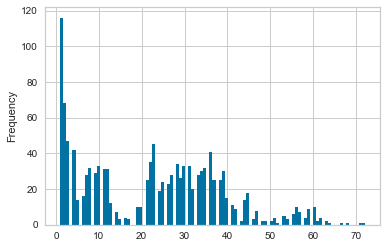

In [63]:
fig, ax = plt.subplots()

y_train.plot(kind='hist', bins=100)

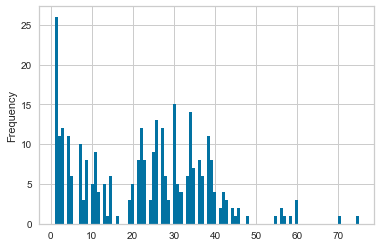

In [64]:
fig, ax = plt.subplots()

y_test.plot(kind='hist', bins=100)

In [65]:
# Calculate the Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(reg.predict(X_test),y_test))
print ("RMSE = %0.3f" % rmse)

RMSE = 7.331


In [66]:
# What are the most important features?
import operator
dict_feat_imp = dict(zip(list(X.columns.values),reg.feature_importances_))

sorted_features = sorted(dict_feat_imp.items(), key=operator.itemgetter(1), reverse=True)
sorted_features

[('longitude', 0.637642844073282),
 ('latitude', 0.3619263611965657),
 ('weekend', 0.00042536494447745703),
 ('minute', 4.768902205615061e-06),
 ('hour', 6.608834691891882e-07)]

In [52]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#get decision tree output 
rf_viz = reg.estimators_[5]
dot_data = StringIO()
export_graphviz(rf_viz, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
graph.write_pdf("stacked-tree.pdf")

True

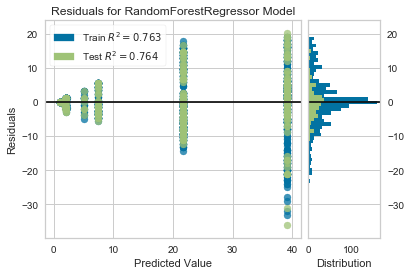

In [53]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(reg, hist=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [54]:
importances = reg.feature_importances_
importances

array([4.18232237e-04, 1.98304815e-06, 1.55281772e-05, 3.54853594e-01,
       6.44710662e-01])

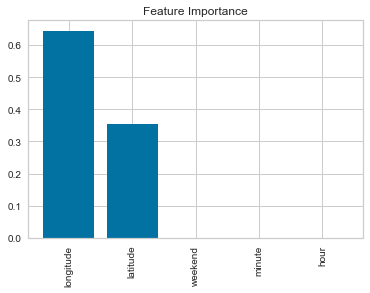

In [55]:
import matplotlib.pyplot as plt
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
features_names = ['weekend', 'hour', 'minute', 'latitude', 'longitude']

# Rearrange feature names so they match the sorted feature importances
names = [features_names[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [56]:
import joblib
# save the model to disk
filename = 'test-stacked finalized_model.sav'
joblib.dump(best, filename)

['test-stacked finalized_model.sav']